In [76]:
import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [77]:
data = pd.read_csv('cs-training-nonull.csv')

# remove unneeded
#data = data.drop('id', axis = 1)

In [90]:
# global constants
N_ESTIMATORS = 100
TARGET = 'SeriousDlqin2yrs'
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

In [91]:
# split in train, validation set
data = data.sample(frac = 1)

N_REC = data.shape[0]

N_TRAIN = int(N_REC * 0.8)
N_VALID = N_REC - N_TRAIN

train_df = data[:N_TRAIN]
valid_df = data[N_TRAIN:]

In [92]:
# estrae X: matrice features ed y, labels
xtrain_df = train_df.drop(TARGET, axis = 1)
x_train = xtrain_df.values
y_train = train_df[TARGET].values

xvalid_df = valid_df.drop(TARGET, axis = 1)
x_valid = xvalid_df.values
y_valid = valid_df[TARGET].values

### Train the XGBoost Classifier

In [93]:
# 22 for early stopping, to avoid overfitting to the train set

param_dist = {'objective':'binary:logistic', 'n_estimators':N_ESTIMATORS}

clf = xgb.XGBClassifier(use_label_encoder=False, **param_dist)

# valuto su train e su validation set
clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_valid, y_valid)],
        eval_metric='auc', verbose=True)

evals_result = clf.evals_result()

[0]	validation_0-auc:0.85290	validation_1-auc:0.84012
[1]	validation_0-auc:0.85609	validation_1-auc:0.84345
[2]	validation_0-auc:0.85985	validation_1-auc:0.84722
[3]	validation_0-auc:0.86078	validation_1-auc:0.84762
[4]	validation_0-auc:0.86144	validation_1-auc:0.84791
[5]	validation_0-auc:0.86227	validation_1-auc:0.84871
[6]	validation_0-auc:0.86486	validation_1-auc:0.85057
[7]	validation_0-auc:0.86800	validation_1-auc:0.85241
[8]	validation_0-auc:0.86929	validation_1-auc:0.85329
[9]	validation_0-auc:0.87087	validation_1-auc:0.85448
[10]	validation_0-auc:0.87261	validation_1-auc:0.85479
[11]	validation_0-auc:0.87429	validation_1-auc:0.85475
[12]	validation_0-auc:0.87596	validation_1-auc:0.85463
[13]	validation_0-auc:0.87688	validation_1-auc:0.85466
[14]	validation_0-auc:0.87842	validation_1-auc:0.85550
[15]	validation_0-auc:0.88011	validation_1-auc:0.85640
[16]	validation_0-auc:0.88084	validation_1-auc:0.85694
[17]	validation_0-auc:0.88199	validation_1-auc:0.85714
[18]	validation_0-au

In [94]:
train_hist = evals_result['validation_0']['auc']
val_hist = evals_result['validation_1']['auc']

In [95]:
def plot_auc(train_hist, val_hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.plot(val_hist, label='Validation AUC')
    plt.title('AUC')
    plt.legend(loc='upper right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

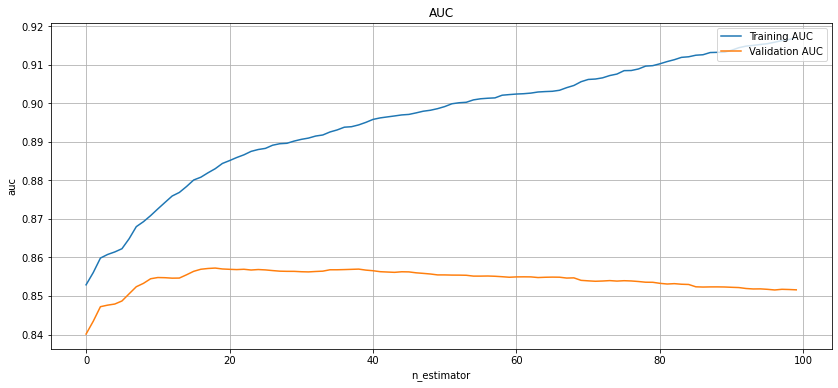

In [96]:
plot_auc(train_hist, val_hist)

In [97]:
# compute accuracy on validation set
y_pred = clf.predict(x_valid)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_valid, predictions)

print("Accuracy on validation set: %.2f%%" % (accuracy * 100.0))

Accuracy on validation set: 93.64%


### Prediction on the TEST set (for submisson to Kaggle)

In [71]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# devo imputare i missing values
# le statistiche per l'inputation le prendo dal train set
orig_data = pd.read_csv('cs-training.csv')
df_stats = orig_data.describe().transpose()
mean_mi = df_stats.loc[COL1_MISSING, 'mean']
mean_nod = df_stats.loc[COL2_MISSING, 'mean']

median_mi = orig_data[COL1_MISSING].median()
mode_nod = orig_data[COL2_MISSING].mode()
# inpute missing values, add the two indicator columns
condition = (orig_test[COL1_MISSING].isnull())

orig_test['isna_mi'] = 0
orig_test.loc[condition, 'isna_mi'] = 1
orig_test.loc[condition, COL1_MISSING] = median_mi

condition = (orig_test[COL2_MISSING].isnull())

orig_test['isna_nod'] = 0

orig_test.loc[condition, 'isna_nod'] = 1
orig_test[COL2_MISSING] = orig_test[COL2_MISSING].fillna(value=int(mode_nod), axis=0)

In [72]:
orig_test

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,isna_mi,isna_nod
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,0,0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,0,0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,0,0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,0,0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101498,101499,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0,0,0
101499,101500,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0,0,0
101500,101501,NaN,0.081596,70,0,836.000000,5400.0,3,0,0,0,0.0,1,1
101501,101502,NaN,0.335457,56,0,3568.000000,5400.0,8,0,2,1,3.0,1,0


In [73]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)
xorig_test = xorig_test.drop(['isna_mi','isna_nod'], axis = 1)

x_test = xorig_test.values

In [74]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test)

y_pred = y_pred[:, 1]

In [75]:
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission1.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')